## HW5
### Cohort 1 Group 7

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')

### Problem 1: Return forecasting regressions
Use the data in ForecastingData.csv, columns E to H, rows 50 to 721. That is, Jan 1967
through Dec 2022. Predict excess returns using a forecasting regression with ináation (cpi),
the adjusted dp, and the term spread on the right hand side. Note that these variables have
already been lagged a month so one can use the numbers in the same row as the excess
returns and it is still a forecasting regression.
The adjusted dp is the current annual log D/P ratio minus the average dp the last 3 years.
This is to avoid the non-stationarity induced by the shift to more repurchases. The original
PD ratio was constructed using the CRSP database monthly market returns ex and cum
dividends, as well as the monthly t-bill rate. Create the market dividend yield by summing
the dividends over the last 12 months and divide by current price (you can do this using ex-
and cum-dividend returns). In particular:
$$ 1 + VWRETD_{t+1} = \frac{P_{t+1}+D_{t+1}}{P_t}$$
$$ 1 + VWRETX_{t+1} = \frac{P_{t+1}}{P_t}$$
$$ \frac{D_{t+1}}{P_t} = VWRETD_{t+1} - VWRETX_{t+1}$$
$$ P_{t+1} = P_t \cdot (1 + VWRETX_{t+1})$$
Start with $P_0 = 1$ to create the price index. The annual dividend based on the monthly
returns is then
$$D_{A,t} = \sum_{j=0}^{11}D_{t-j}$$
The price-dividend ratio is then
$$PD_t = P_t/D_{A,t}$$
1. Construct log excess returns by subtracting the log of the 1-month gross t-bill rate
from the 1-month gross cum-dividends returns. Note: to get to gross returns you may
have to add 1 to the original data series.
The variable y10minFF is the difference between the yield on a 10-year Treasury and
the Fed Funds rate (a short term interest rate), which you can download from the
FRED database (google it).

In [2]:
df_ret = pd.read_csv("ForecastingData.csv")
df_ret = df_ret[['caldt', 'l.cpi', 'l.y10minFF', 'l.dp_adj', 'ExcessRet']]
df_ret = df_ret.dropna(subset=['l.dp_adj'])
df_ret['caldt'] = df_ret['caldt'].astype('str').apply(lambda x: x[:-2])
df_ret = df_ret.rename(columns={'caldt': 'ts'})

In [3]:
df_rf = pd.read_csv("F-F_Research_Data_Factors.csv", skiprows=3)[:1169]
df_rf.columns = ['ts','Mkt-RF','SMB','HML','RF']
df_rf['RF'] = pd.to_numeric(df_rf['RF']) / (100 * 12)

In [4]:
df = pd.merge(df_ret,df_rf[['ts','RF']],on='ts',how='left')
df['ts'] = pd.to_datetime(df['ts'], format="%Y%m")
df['ln.rf'] = np.log(1+df['RF'])
df['ln.ret'] = np.log(1+df['RF']+df['ExcessRet'])
df['ln.ex'] = df['ln.ret']-df['ln.rf']
df.head()

,ts,l.cpi,l.y10minFF,l.dp_adj,ExcessRet,RF,ln.rf,ln.ret,ln.ex
0,1967-01-01,0.00000,-0.0036,0.148263,0.078149,0.000358,0.000358,0.075578,0.075220
1,1967-02-01,0.00000,0.0052,0.152243,0.007150,0.000300,0.000300,0.007422,0.007122
2,1967-03-01,0.00000,-0.0003,0.060992,0.038783,0.000325,0.000325,0.038363,0.038038
3,1967-04-01,0.00304,0.0000,0.048677,0.037428,0.000267,0.000267,0.037002,0.036735
4,1967-05-01,0.00303,0.0078,0.003264,-0.043207,0.000275,0.000275,-0.043881,-0.044156


2. Plot your data with the date on the horizontal axis. Describe each of the series with
words. Give the ACF of each series.

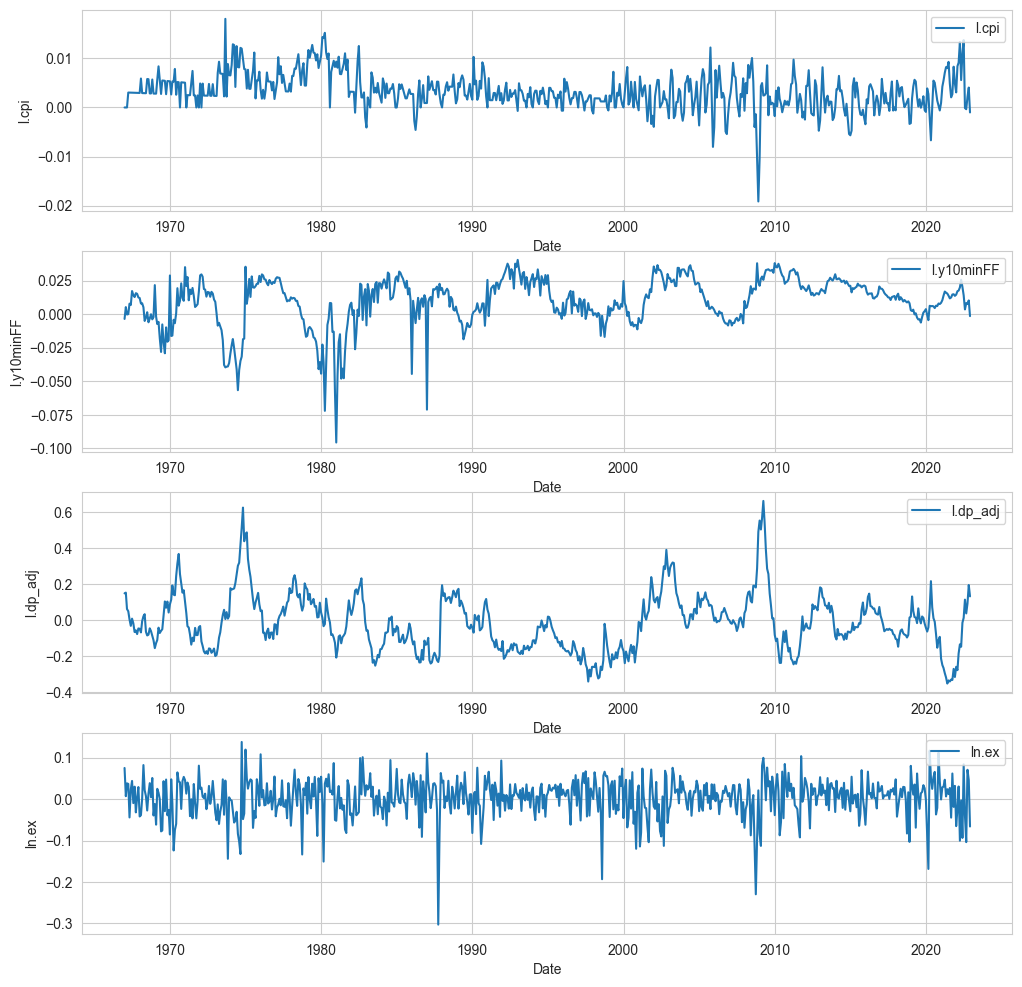

<Figure size 640x480 with 0 Axes>

In [5]:
plt.figure(figsize=(12, 12))
series = ['l.cpi','l.y10minFF','l.dp_adj','ln.ex']

for i in range(len(series)):
    name = series[i]
    plt.subplot(4, 1, i+1)
    plt.plot(df['ts'],df[name],label=name)
    plt.xlabel('Date')
    plt.ylabel(name)
    plt.legend(loc='upper right')
plt.show()
plt.tight_layout()

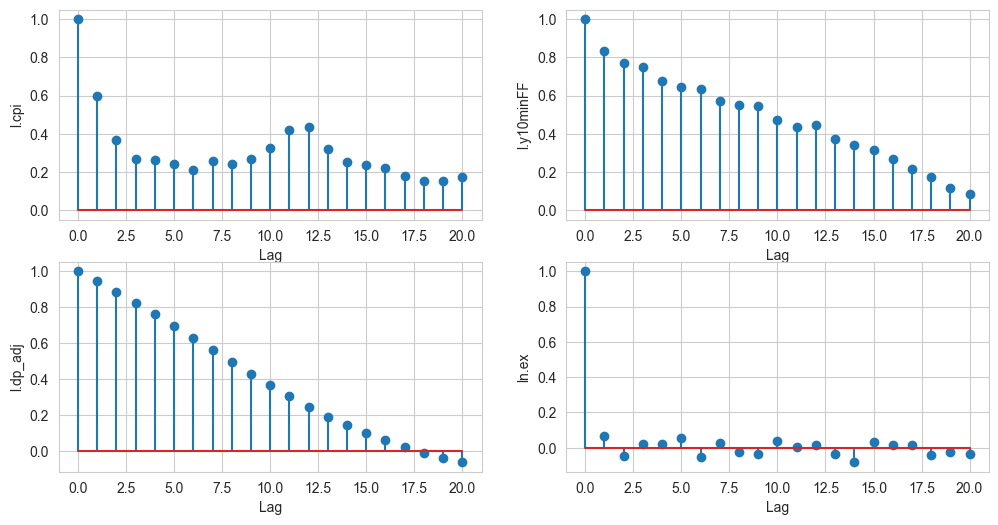

<Figure size 640x480 with 0 Axes>

In [6]:
from statsmodels.tsa.stattools import acf, pacf
lags= 20
series = ['l.cpi','l.y10minFF','l.dp_adj','ln.ex']
plt.figure(figsize=(12, 6))

for i in range(len(series)):
    name = series[i]
    acf_values = acf(df[name], nlags=lags)
    plt.subplot(2, 2, i+1)
    plt.stem(range(lags + 1), acf_values)
    plt.xlabel('Lag')
    plt.ylabel(name)
plt.show()
plt.tight_layout()

#### Answer
l.cpi: This series appears to be stationary around a mean of zero, showing no clear trend over time, which suggests that the inflation has been de-trended or seasonally adjusted. The ACF plot for l.cpi shows a strong positive autocorrelation at the first lag, which quickly diminishes as the lags increase.

l.y10minFF: The series for the term spread (10-year Treasury minus the Federal Funds rate) shows more variability in earlier years, with a steadying pattern around the year 2000. The ACF plot indicates a gradual decline in autocorrelation as the lags increase, with significant positive autocorrelation persisting for several lags.

l.dp_adj: This series represents the log of the adjusted dividend-price ratio and shows significant fluctuations over time with some sharp spikes, which could be indicative of market events affecting dividend yields or stock prices. The ACF plot reveals a strong persistent autocorrelation across many lags, suggesting a slow-moving process.

ln.ex: This series reflects log excess returns and seems to be quite stationary with no evident trend. The ACF plot indicates that there is negligible autocorrelation, as the values drop off quickly and remain within the confidence interval after the first lag.

3. Using your three predictive variables (the lagged adjusted dividend yield, term spread, and inflation), forecast excess equity returns at the 12-month horizons using this
monthly data. Report the coefficients, standard errors, and R2. The underlying data
is monthly, so make sure to explain your choice of standard errors.

In [7]:
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

df['ex.12'] = df['ln.ex'].shift(-11).rolling(12).sum()
df['rf.12'] = df['ln.rf'].shift(-11).rolling(12).sum()
df['ret.12'] = df['ln.ret'].shift(-11).rolling(12).sum()
df = df.dropna()
model = sm.OLS(df['ex.12'], sm.add_constant(df[['l.cpi', 'l.y10minFF', 'l.dp_adj']])).fit(cov_type='HAC',cov_kwds={'maxlags':17})
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  ex.12   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     6.568
Date:                Sat, 10 Feb 2024   Prob (F-statistic):           0.000223
Time:                        21:21:45   Log-Likelihood:                 266.14
No. Observations:                 650   AIC:                            -524.3
Df Residuals:                     646   BIC:                            -506.4
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0429      0.028      1.547      0.1

#### Answer
lags = (k-1) × 1.5

4. Plot the estimated expected 12-month excess return. What type of periods are asso
ciated with high expected returns and what type of periods are associated with low
expected returns? Does the patterns make sense to you? What are the economic
stories you would tell to explain these patterns?

[*********************100%%**********************]  1 of 1 completed


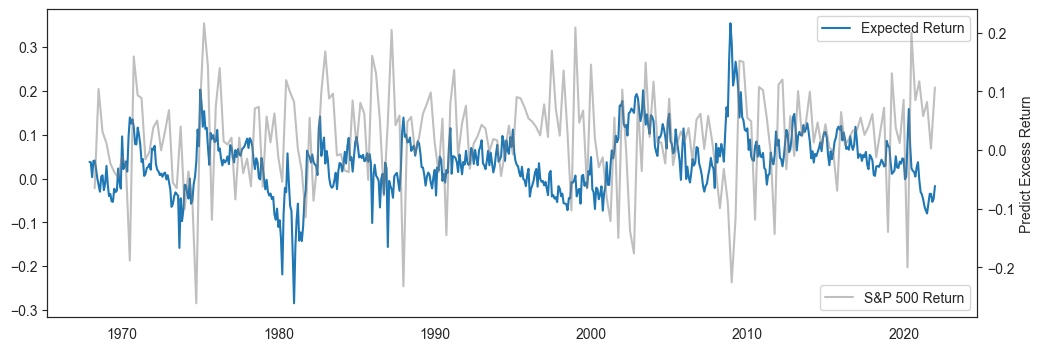

In [9]:
import yfinance as yf

pred = model.predict(sm.add_constant(df[['l.cpi', 'l.y10minFF', 'l.dp_adj']]))
pred = pd.DataFrame({'ts': df['ts'], 'pred': pred})

startdate = pred.ts.dt.strftime("%Y-%m-%d").values[0]
enddate = pred.ts.dt.strftime("%Y-%m-%d").values[-1]
data = yf.download('^GSPC',start=startdate, end=enddate)
data_m= data['Adj Close'].resample('3M').last()
data_m_ret = data_m.pct_change()

sns.set_style('white')
plt.figure(figsize=(12,4))
plt.plot(pred['ts'],pred['pred'],label='Expected Return')
plt.legend()
ax = plt.twinx()
ax.plot(data_m_ret,color='grey',alpha=0.5,label='S&P 500 Return')
plt.xlabel('Date')
plt.ylabel('Predict Excess Return')
plt.legend()
plt.show()

#### Answer
High Expected Returns: These are likely during periods of economic optimism, when investors anticipate growth, or when market valuations are low, suggesting a potential for appreciation.

Low Expected Returns: These are often during times of economic pessimism, high market valuations, or when investors expect negative future events that could affect the market.

The pattern make since as high expected returns might follow economic downturns as markets rebound, while low expected returns could come after long periods of growth when future returns are already reflected in high asset prices.

5. Calculate the Sharpe ratio of a strategy that rebalances once a year (at the end of
December) and uses portfolio loading $\omega_t = \mu_t$ on the market, where $\mu_t = E_t(r_{t+12})$ from your forecasting regression. That is compute strategy returns as $\omega_tR_{t,t+12}^e$, where $\omega_t$ is the time t expected return and $\omega_tR_{t,t+12}^e$ is the excess annual market return. Compare this to the Sharpe ratio of a buy-and-hold strategy (that is, simply using the returns $\omega_tR_{t,t+12}^e$).

In [10]:
df['pred'] = model.predict(sm.add_constant(df[['l.cpi', 'l.y10minFF', 'l.dp_adj']]))
df['Dynamic'] = df['pred'].shift(-1) * df['ret.12'] + (1-df['pred'].shift(-1))*df['rf.12'] - df['rf.12']
df['BuyHold'] = df['ex.12']

names = ['Dynamic','BuyHold']
col = ['Excess_Return','Volatility','Sharpe_Ratio']
result = pd.DataFrame(index=names,columns=col)

for name in names:
    result.loc[name,'Excess_Return'] = df[name].mean()
    result.loc[name,'Volatility'] = df[name].std()

result['Sharpe_Ratio'] = result['Excess_Return']/result['Volatility']
result

,Excess_Return,Volatility,Sharpe_Ratio
Dynamic,0.005836,0.015159,0.384966
BuyHold,0.038218,0.173999,0.219647


#### Answer
The Sharpe ratio for the dynamic strategy is approximately 0.385, which is higher than the Sharpe ratio for the buy-and-hold strategy at approximately 0.220. This indicates that the dynamic strategy provided a better risk-adjusted return than the buy-and-hold strategy over the same period. The higher Sharpe ratio suggests that the dynamic strategy achieved higher excess returns per unit of risk, which could be due to more efficient timing or a better forecasting model.

### Problem 2: M/B ratios and the present value formula
In class, we derived a log-linear present value formula using the Campbell-Shiller return decomposition ($r_{t+1}\approx k_0+\rho \cdot pd_{t+1}-pd_t + \Delta d_{t+1}$). While this decomposition is very accurate, it does require a stationary pd-ratio and positive dividends. Many firms do not pay
dividends, which means this formula is not always useful at the firm level.
However, Ohlson (Contemporary Accounting Research, 1995) and Vuolteenaho (Journal
of Finance, 2002) derive a return decomposition that uses market-to-book ratios and return-on-equity instead of the pd-ratio and dividends (See also Lochstoer and Tetlock (Journal of Finance, 2022)). In particular, the alternative return decomposition is:
$$r_{t+1} \approx k \cdot mb_{t+1} - mb_t + roe_{t+1}$$
where $k = 0.97$ with annual data, $mb_t = lnM_t/B_t$ and $roe_t = ln(1 + ROE_t)$. Here, $M_t$ is the market value of equity, $B_t$ is the book value of equity, $ROE_t = \frac{E_t}{B_{t-1}}$ is return-on-equity where $E_t$ is earnings. See the above papers for details. With this decomposition we have:
$$mb_t \approx E_t(\sum_{j=1}^{\infty}k^{j-1}roe_{t+j}) - E_t(\sum_{j=1}^{\infty}k^{j-1}r_{t+j})$$
where $E_t(\cdot)$ is the conditional expectations operator. Thus, if the market-to book ratio is high today, either future expected return on equity is high or expected future returns are low. Vice versa if the market-to-book ratio is low today.
1. You estimate a firms annual roe to follow the ARMA(1,1):
$$roe_{t+1} = 0.05 + 0.9(roe_t - 0.05) - 0.6\varepsilon_t + \varepsilon_{t+1}$$
where $\sigma(\varepsilon_t) = 0.1$. Assume the current value of $mb_t = \frac{lnM_t}{B_t} = 0.7$, $roe_t =
ln(1 + ROE_t)$ where $ROE_t = 0.2$, and $\varepsilon_t = 0.1$. From this information, derive the current value of the below:
$$CF_t = E_t(\sum_{j=1}^{\infty}k^{j-1}roe_{t+j})$$
Note that you can then obtain
$$DR_t = E_t(\sum_{j=1}^{\infty}k^{j-1}roe_{t+j}) = CF_t - mb_t$$
where $(1 - k)\cdot DR_t$ is an annualized measure of the long-run expected returns. What is the current value of this expected long-run return?

$E_t[roe_{t+1}]=0.05+0.9(roe_t-0.05)-0.6\varepsilon_{t}+E_t[\varepsilon_{t+1}] = 0.109$ <br>
$E_t[roe_{t+2}] = 0.05 + 0.9(E_t[roe_{t+1}]-0.05) = 0.103$ <br>
$E_t[roe_{t+j}] = 0.05 + 0.9^{j-1}(E_t[roe_{t+1}]-0.05)$ <br>

$CF_t = \sum_{j=1}^{\infty}k^{j-1}E_t(roe_{t+j})=2.13$ <br>
$DR_t = E_t(\sum_{j=1}^{\infty}k^{j-1}roe_{t+j}) = CF_t - mb_t = 1.43$

2. Next, assume a different firm in the same industry also has roe that follows an ARMA(1,1) with the same parameters (for instance, you estimated the parameters of the ARMA using industrywide ROE data). For this firm, $ROE_t = 0.1$, $\varepsilon_t = - 0.05$, and $mb_t = 0.7$. What is the current value of this firmís annualized long-run expected return? If you are a value-investor, which firm would you choose?

$E_t[roe_{t+1}]=0.05+0.9(roe_t-0.05)-0.6\varepsilon_{t}+E_t[\varepsilon_{t+1}] = 0.121$ <br>
$E_t[roe_{t+j}] = 0.05 + 0.9^{j-1}(E_t[roe_{t+1}]-0.05)$ <br>

$CF_t = \sum_{j=1}^{\infty}k^{j-1}E_t(roe_{t+j})=0.8$ <br>
$DR_t = E_t(\sum_{j=1}^{\infty}k^{j-1}roe_{t+j}) = CF_t - mb_t = 0.1$

#### Answer
In comparing two firms for a value investment decision based on their long-run expected returns and market-to-book ratios:

**First Firm:** \
$DR_t = 1.43$ \
Market-to-Book Ratio $ mb_t = 0.7$

**Second Firm:** \
$DR_t = 0.1$ \
Market-to-Book Ratio $mb_t = 0.7$

Given that the market-to-book ratio is the same for both firms, as a value investor, the decision would hinge on the $ DR_t $ values, representing the long-run expected returns after accounting for the market valuation. The first firm, with a higher $ DR_t $ of 1.43, indicates better long-run expected returns compared to the second firm's $ DR_t $ of 0.1.

Therefore, the firm with the higher $ DR_t $ would generally be considered more attractive for investment.